### Fastai Pretrained Resnet using custom soccer dataset ###
1.Iswariya Manivannan<br>
2.Sathiya Ramesh

In [1]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import torch

import numpy as np
import PIL
import matplotlib.pyplot as plt

In [2]:
torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [55]:
# Path of dataset
PATH = '/opt/datasets/Robocup_soccer/'
print(os.listdir(f'{PATH}'))

size_of_image = 224
arch = resnet101  # Using resnet101 architecture
batch_size = 32  # Using a small batch size because of limited training data

['train', 'tmp', 'models', 'test', 'valid']


There are 508 (with ball) and 504 (without ball)training samples


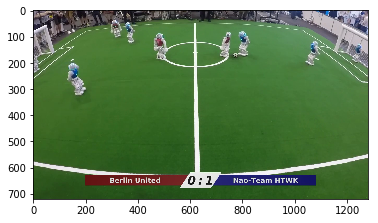

In [56]:
with_ball_samples = os.listdir(f'{PATH}/train/with_ball')
without_ball_samples = os.listdir(f'{PATH}/train/without_ball')
print(f'There are {len(with_ball_samples)} (with ball) and {len(without_ball_samples)} (without ball)training samples') 

img = plt.imread(f'{PATH}/train/with_ball/{with_ball_samples[11]}')
plt.imshow(img)

In [57]:
# Data augmentation such as flipping the sides
transforms = tfms_from_model(arch, size_of_image, aug_tfms=transforms_side_on)
# Loading the data
data = ImageClassifierData.from_paths(PATH, tfms=transforms, bs = batch_size,test_name='test')
# Setting precompute to true for initial training
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.001, 10)

epoch      trn_loss   val_loss   accuracy                  
    0      0.670215   0.425237   0.79      
    1      0.541394   0.40363    0.83                      
    2      0.462615   0.38113    0.83                      
    3      0.419417   0.355513   0.84                      
    4      0.389565   0.365031   0.83                      
    5      0.360003   0.361977   0.84                      
    6      0.332052   0.367606   0.83                      
    7      0.316837   0.373124   0.86                      
    8      0.303853   0.361737   0.84                      
    9      0.29767    0.36552    0.85                      


[array([0.36552]), 0.85]

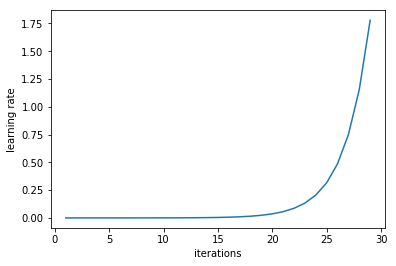

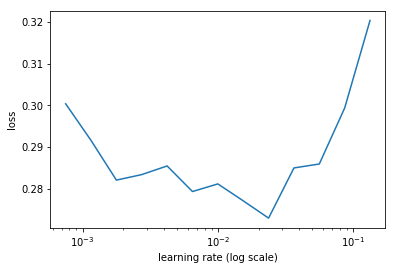

In [58]:
# Using learning rate scheduler and plotting learning rates to find the best learning rate
def learning_rate_plots(learn):
    lrf =learn.lr_find()
    plt.figure()
    learn.sched.plot_lr()
    plt.figure()
    learn.sched.plot()
    
learning_rate_plots(learn)  

In [59]:
# Setting precompute to false, hence augmented data should increase the accuracy
learn.precompute=False
learn.fit(0.01,6, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.460665   0.460446   0.79      
    1      0.413783   0.392031   0.84                      
    2      0.416345   0.46434    0.75                      
    3      0.411808   0.436347   0.82                      
    4      0.391962   0.330645   0.86                      
    5      0.371585   0.347713   0.86                      
    6      0.372323   0.33387    0.86                      
    7      0.36284    0.346946   0.84                      
    8      0.335404   0.331994   0.84                      
    9      0.325935   0.325716   0.86                      
    10     0.330199   0.319473   0.84                      
    11     0.336273   0.303414   0.87                      


[array([0.30341]), 0.87]

 91%|█████████ | 29/32 [00:13<00:01,  2.16it/s, loss=1.39] 

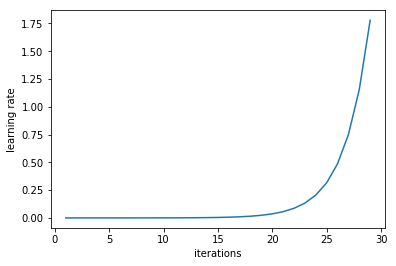

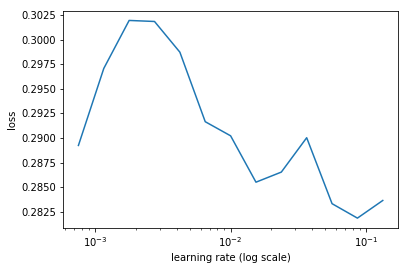

In [60]:
learning_rate_plots(learn)

In [61]:
# Unfreezing the layers and using differential learning for diff layers
learn.unfreeze()
lr = np.array([1e-4, 1e-3, 1e-2])
learn.fit(lr, 6, cycle_len=2, best_save_name='Best_model')

epoch      trn_loss   val_loss   accuracy                  
    0      0.517051   0.346159   0.83      
    1      0.411805   0.361088   0.86                      
    2      0.363423   0.357252   0.82                      
    3      0.29882    0.332494   0.85                      
    4      0.272989   0.3753     0.82                      
    5      0.242765   0.353092   0.89                      
    6      0.233205   0.353052   0.88                      
    7      0.19948    0.338223   0.89                      
    8      0.188331   0.483839   0.85                      
    9      0.169086   0.411216   0.87                      
    10     0.158106   0.485902   0.86                      
    11     0.155209   0.460051   0.86                      


[array([0.46005]), 0.86]

In [69]:
learn.data.classes

['with_ball', 'without_ball']

In [83]:
learn.load('Best_model')  # Loading the best model weights
log_preds = learn.predict()
pred_label = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
accuracy = (total - len(np.where(pred_label!=data.val_y)[0]))/total
print(f"Accuracy:{accuracy}")

Accuracy:0.89


In [85]:
log_pred,targets = learn.TTA()  # Obtaining predictions using Test time augmentation

probs = np.mean(np.exp(log_pred),0)
accuracy_np(probs, targets)

0.9

[[45  5]
 [ 6 44]]


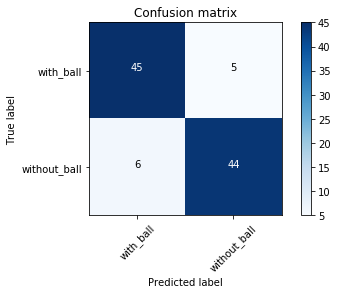

In [87]:
# Plotting confusion matrix
from sklearn.metrics import confusion_matrix
preds = np.argmax(log_preds, axis=1)
cm = confusion_matrix(targets, preds)
plot_confusion_matrix(cm, data.classes)